# Image Classification of Cats and Dogs

![Project Image](cat_dog_image.jpg)

## Outline

<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#loading">Data Loading</a></li>
<li><a href="#preprocessing">Preprocessing</a></li>
<li><a href="#building">Model Building</a></li>
<li><a href="#evaluation">Model Evaluation</a></li>
<li><a href="#conclusion">Conclusion</a></li>
</ul>

<a id='intro'></a>
## Introduction

This project focuses on developing a robust neural network model for image classification of cats and dogs. By leveraging transfer learning with a pre-trained MobileNetV2 model, the goal is to achieve high accuracy and strong generalization on unseen data. Transfer learning utilizes models that have been pre-trained on large, diverse datasets, thereby accelerating the training process and enhancing model performance. Through careful preprocessing and model fine-tuning, an effective classifier is built for deployment in real-world applications. This project outlines the steps taken to preprocess the data, build and train the model, and evaluate its performance using training and validation metrics.

<a id='loading'></a>
## Data Loading

In [1]:
# import libraries

import os
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras import layers, Model
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [2]:
# delete corrupted images if present

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


In [3]:
# load data and split into train and validation sets

train, val = keras.utils.image_dataset_from_directory(
    directory ="PetImages",
    label_mode="binary",
    batch_size = 128,
    image_size=(128, 128),
    seed=42,
    validation_split=0.2,
    subset="both",
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


In [4]:
# confirm binary categories

class_names = train.class_names
class_names

['Cat', 'Dog']

In [5]:
# confirm binary label assigned to categories

for name in class_names:
    print('{}: {}'.format(name, class_names.index(name)))

Cat: 0
Dog: 1


In [6]:
# confirm image and label shapes for one batch

for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(int(labels_batch[0]))
  break

(128, 128, 128, 3)
1


<a id='preprocessing'></a>
## Preprocessing

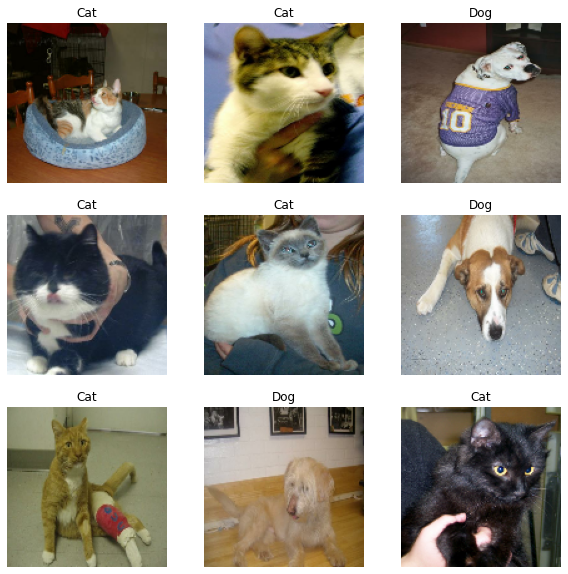

In [7]:
# view first 9 images of train set

plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

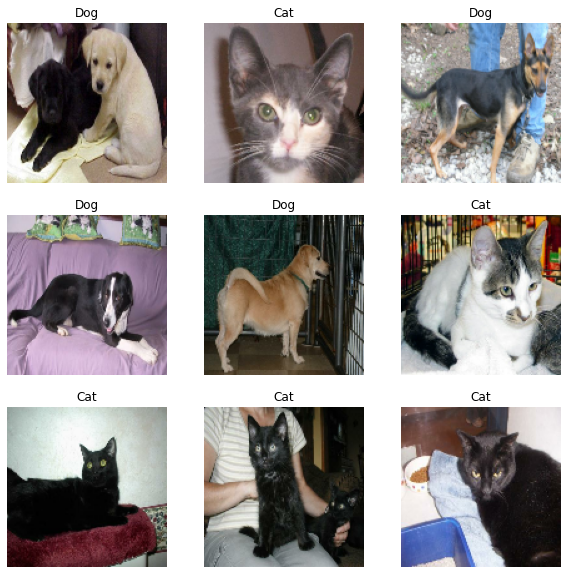

In [8]:
# view first 9 images of validation set

plt.figure(figsize=(10, 10))
for images, labels in val.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

### Apply preprocessing layers to the datasets and configure for performance using parallel reads and buffered prefetching

In [9]:
# define data augmentation prepocessing layers to be applied

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2)
])

In [10]:
# Set runtime tuning to AUTOTUNE

AUTOTUNE = tf.data.AUTOTUNE

In [11]:
# define preprocessing function to scale, cache, shuffle, augment and prefetch data

def preprocessing(ds, shuffle=False, augment=False):
    
    # scale input pixels of datasets between -1 and 1 using MobileNetV2's preprocess_input function 
    ds = ds.map(lambda img, label: (preprocess_input(img), label), 
                num_parallel_calls=AUTOTUNE)
    
    # cache all datasets
    ds = ds.cache()
    
    # shuffle only on the training set
    if shuffle:
        ds = ds.shuffle(1000)
    
    # use data augmentation only on the training set 
    # also apply augmentation after caching to avoid caching randomness
    if augment:
        ds = ds.map(lambda img, label: (data_augmentation(img), label),
                    num_parallel_calls=AUTOTUNE)
    
    # prefetch data to decouple time when data is produced from time when data is consumed
    return ds.prefetch(buffer_size=AUTOTUNE)

In [12]:
# apply preprocessing function on train and validation sets

train = preprocessing(train, shuffle=True, augment=True)
val = preprocessing(val)

<a id='building'></a>
## Model Building

In [13]:
# define MobileNetV2 as base model with pretrained weights

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [14]:
# freeze all layers in base model to avoid updates of layer’s parameters (weights and biases) during training

for layer in base_model.layers:
    layer.trainable = False

In [15]:
# view base model summary

base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[

 block_3_expand_relu (ReLU)  (None, 32, 32, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 33, 33, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 16, 16, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 16, 16, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 8, 8, 192)            768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 8, 8, 192)            0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 8, 8, 64)             12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 8, 8, 64)             256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 8, 8, 64)             0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 8, 8, 384)            24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 8, 8, 384)            1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 8, 8, 384)            0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 8, 8, 576)            0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 9, 9, 576)            0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 4, 4, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 4, 4, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 4, 4, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 4, 4, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [16]:
# create new model with additional custom layers on top of base model to adapt it to the task

model = Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [17]:
# compile the model

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
# train the model

history = model.fit(train, epochs=15, validation_data=val)

Epoch 1/15
147/147 [==============================] - 294s 2s/step - loss: 0.2315 - accuracy: 0.9288 - val_loss: 0.0594 - val_accuracy: 0.9774
Epoch 2/15
147/147 [==============================] - 204s 1s/step - loss: 0.1282 - accuracy: 0.9472 - val_loss: 0.0542 - val_accuracy: 0.9793
Epoch 3/15
147/147 [==============================] - 202s 1s/step - loss: 0.1256 - accuracy: 0.9485 - val_loss: 0.0557 - val_accuracy: 0.9795
Epoch 4/15
147/147 [==============================] - 203s 1s/step - loss: 0.1181 - accuracy: 0.9518 - val_loss: 0.0517 - val_accuracy: 0.9795
Epoch 5/15
147/147 [==============================] - 199s 1s/step - loss: 0.1082 - accuracy: 0.9575 - val_loss: 0.0509 - val_accuracy: 0.9812
Epoch 6/15
147/147 [==============================] - 239s 2s/step - loss: 0.1056 - accuracy: 0.9577 - val_loss: 0.0526 - val_accuracy: 0.9795
Epoch 7/15
147/147 [==============================] - 202s 1s/step - loss: 0.0974 - accuracy: 0.9618 - val_loss: 0.0536 - val_accuracy: 0.9801

<a id='evaluation'></a>
## Model Evaluation

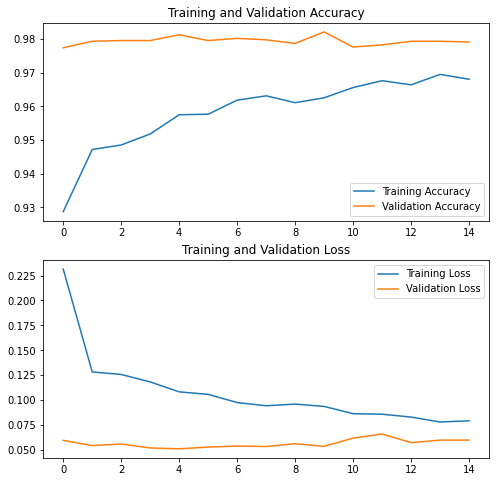

In [19]:
# create plots of loss and accuracy on training and validation sets

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=15
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

> The plots above indicate a well performing model, with both high training and validation accuracies. The training process shows effective learning with a stable and high validation accuracy, suggesting that the model generalizes well to unseen data. The training and validation losses further support this, showing minimal divergence and stable values throughout the epochs.

### Fine-tune model by freezing only bottom 100 layers of the base pre trained model and retrain

In [20]:
# keep bottom 100 layers frozen and unfreeze top layers

for layer in base_model.layers[100:]:
    layer.trainable = True

In [21]:
# recompile model with a lower learning rate

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
# retrain fine-tuned model

history_fine_tuned = model.fit(train, epochs=15, validation_data=val)

Epoch 1/15
147/147 [==============================] - 347s 2s/step - loss: 0.1596 - accuracy: 0.9349 - val_loss: 0.0634 - val_accuracy: 0.9786
Epoch 2/15
147/147 [==============================] - 320s 2s/step - loss: 0.1173 - accuracy: 0.9509 - val_loss: 0.0683 - val_accuracy: 0.9774
Epoch 3/15
147/147 [==============================] - 315s 2s/step - loss: 0.1028 - accuracy: 0.9589 - val_loss: 0.0633 - val_accuracy: 0.9795
Epoch 4/15
147/147 [==============================] - 316s 2s/step - loss: 0.0975 - accuracy: 0.9603 - val_loss: 0.0658 - val_accuracy: 0.9769
Epoch 5/15
147/147 [==============================] - 317s 2s/step - loss: 0.0890 - accuracy: 0.9649 - val_loss: 0.0601 - val_accuracy: 0.9799
Epoch 6/15
147/147 [==============================] - 330s 2s/step - loss: 0.0846 - accuracy: 0.9668 - val_loss: 0.0633 - val_accuracy: 0.9780
Epoch 7/15
147/147 [==============================] - 312s 2s/step - loss: 0.0779 - accuracy: 0.9700 - val_loss: 0.0615 - val_accuracy: 0.9789

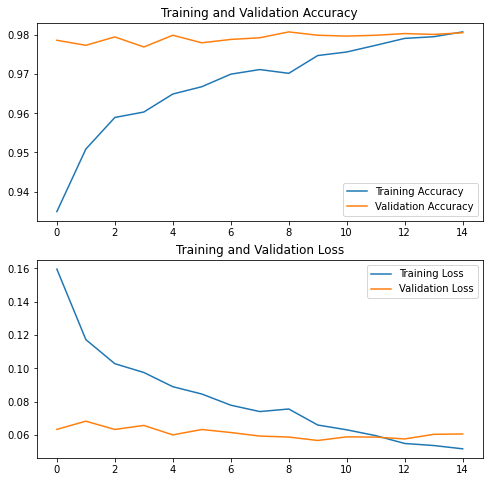

In [23]:
# create plots of updated loss and accuracy on training and validation sets

acc_fine_tuned = history_fine_tuned.history['accuracy']
val_acc_fine_tuned = history_fine_tuned.history['val_accuracy']

loss_fine_tuned = history_fine_tuned.history['loss']
val_loss_fine_tuned = history_fine_tuned.history['val_loss']

epochs=15
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc_fine_tuned, label='Training Accuracy')
plt.plot(epochs_range, val_acc_fine_tuned, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss_fine_tuned, label='Training Loss')
plt.plot(epochs_range, val_loss_fine_tuned, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

> The plots above show a slightly better performance by the fine-tuned model, with higher training and validation accuracies

### Test model on samples treated as unseen images

In [24]:
# define function to run inference on samples treated as unseen images

def sample(folder, file_numbers):
    plt.figure(figsize=(20, 12))
    print('\n{} predictions:'.format(folder))
    for number in file_numbers:
            try:
                # load image and resize it to the target size
                sample_image = image.load_img("PetImages/{}/{}.jpg".format(folder, number), target_size = (128, 128))
                
                # convert image to a numpy array
                sample = image.img_to_array(sample_image)
                
                # expand dimensions to match input shape expected by the model
                sample = np.expand_dims(sample, axis = 0)
                
                # preprocess image using MobileNetV2's preprocess function
                sample = preprocess_input(sample)
                
                # run prediction
                result = model.predict(sample, verbose = 0)
                print(result[0][0])

                # define prediction based on result
                # note that labeling was done using alphanumerical order of subdirectories(0 for cat, 1 for dog)
                prediction = 'dog' if result[0][0] >= 0.5 else 'cat'

                # view image with file number and prediction as title
                ax = plt.subplot(1, 5, file_numbers.index(number) + 1)
                plt.imshow(sample_image)
                plt.title('file {} - {}'.format(number, prediction))
                plt.axis("off")
            except Exception:
                print('file number {} not present in directory'.format(number))


Cat predictions:
2.2545553e-05
1.2218599e-05
0.00672348
1.2698943e-07
3.6006565e-08

Dog predictions:
0.99379945
0.98753786
1.0
1.0
0.9999998


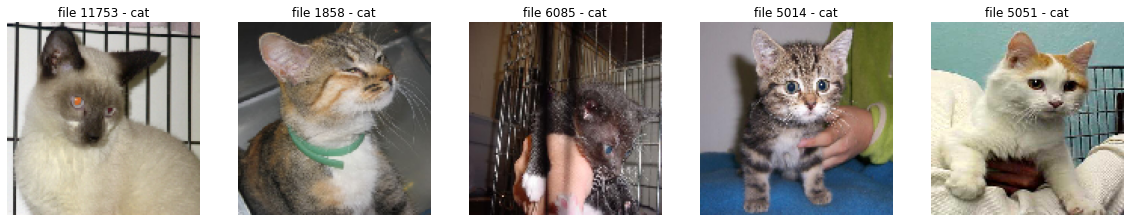

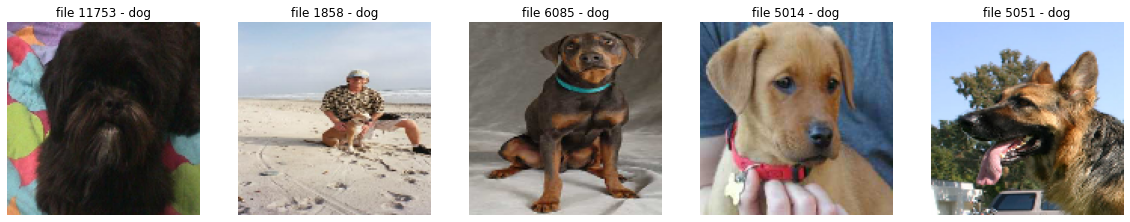

In [25]:
# run sample function on randomly selected files

file_numbers = np.random.randint(12499, size = 5)

sample('Cat', list(file_numbers))
sample('Dog', list(file_numbers))

<a id='conclusion'></a>
## Conclusion

Both the inital and fine-tuned models are well-trained with effective generalization. Overall, the fine-tuned model can be considered slightly better due to its stability and higher final training and validation accuracies.

The analysis of training and validation metrics demonstrates the model's strong performance in image classification tasks. The training accuracy steadily increased, reaching 98% by the final epoch, while the validation accuracy remained high and stable around 98%. The training loss showed a significant reduction, stabilizing at approximately 0.05, and the validation loss remained consistently low around 0.06. These results indicate that the model has effectively learned the features of the dataset and generalizes well to unseen data, making it a reliable tool for deployment in real-world applications.